
# Final Grid Pathfinding Benchmark (A\*, Dijkstra, DFS, JPS) 



In [ ]:

# Imports, artifact folder, manifest
import os, sys, time, math, random
from dataclasses import dataclass
from typing import List, Tuple, Dict, Any, Callable, Optional
from heapq import heappush, heappop

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

try:
    import psutil
except Exception:
    psutil = None

# Accesses the path of the root folder
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)
    
from src.algorithms.jps import *
from src.algorithms.astar import *


ARTIFACTS = os.path.join('.', 'artifacts_all_in_one')
os.makedirs(ARTIFACTS, exist_ok=True)

def manifest():
    return {
        "python": sys.version.split()[0],
        "numpy": np.__version__,
        "pandas": pd.__version__,
        "matplotlib": plt.matplotlib.__version__,
        "psutil_available": bool(psutil),
    }
print('Manifest:', manifest())


Manifest: {'python': '3.13.7', 'numpy': '2.2.4', 'pandas': '2.3.2', 'matplotlib': '3.10.1', 'psutil_available': True}


In [28]:

# Maze generation
def generate_maze_dfs_seeded(width:int, height:int, seed:int=0)->np.ndarray:
    rng = random.Random(seed)
    maze = np.ones((height,width), dtype=int)
    stack=[(1,1)]
    maze[1,1]=0
    dirs=[(-2,0),(2,0),(0,-2),(0,2)]
    while stack:
        y,x=stack.pop()
        rng.shuffle(dirs)
        for dy,dx in dirs:
            ny,nx=y+dy,x+dx
            if 1<=ny<height-1 and 1<=nx<width-1 and maze[ny,nx]==1:
                maze[ny,nx]=0
                maze[y+dy//2,x+dx//2]=0
                stack.append((ny,nx))
    maze[1,1]=0
    maze[height-2,width-2]=0
    return maze

def add_loops(maze:np.ndarray, p:float, seed:int=0)->np.ndarray:
    rng=np.random.default_rng(seed)
    out=maze.copy()
    H,W=out.shape
    for y in range(1,H-1):
        for x in range(1,W-1):
            if out[y,x]==1 and rng.random()<p:
                out[y,x]=0
    return out

def free_cells(m:np.ndarray)->int:
    return int(np.sum(m==0))

def hygiene()->None:
    import gc; gc.collect(); time.sleep(0.0)


In [29]:

# Algorithms with unified return dict

def dfs_metrics(maze:np.ndarray, start:Tuple[int,int], end:Tuple[int,int])->Dict[str,Any]:
    H,W=maze.shape
    visited=np.zeros((H,W),dtype=bool)
    visited[start]=True
    stack=[(start[0],start[1],[start])]
    dirs=[(-1,0),(1,0),(0,-1),(0,1)]
    expanded=0; generated=1; peak_frontier=len(stack); peak_closed=0
    expanded_order=[]; pop_times_ns=[]; t0=time.perf_counter_ns()
    while stack:
        y,x,path=stack.pop()
        expanded+=1; peak_closed+=1
        expanded_order.append((y,x))
        pop_times_ns.append(time.perf_counter_ns()-t0)
        peak_frontier=max(peak_frontier,len(stack))
        if (y,x)==end:
            return {"path":path,"nodes_expanded":expanded,"nodes_generated":generated,
                    "peak_frontier":peak_frontier,"peak_closed":peak_closed,
                    "expanded_order":expanded_order,"pop_times_ns":pop_times_ns}
        for dy,dx in dirs:
            ny,nx=y+dy,x+dx
            if 0<=ny<H and 0<=nx<W and maze[ny,nx]==0 and not visited[ny,nx]:
                visited[ny,nx]=True; generated+=1
                stack.append((ny,nx,path+[(ny,nx)]))
                peak_frontier=max(peak_frontier,len(stack))
    return {"path":[],"nodes_expanded":expanded,"nodes_generated":generated,
            "peak_frontier":peak_frontier,"peak_closed":peak_closed,
            "expanded_order":expanded_order,"pop_times_ns":pop_times_ns}

def dijkstra_metrics(maze:np.ndarray, start:Tuple[int,int], end:Tuple[int,int])->Dict[str,Any]:
    H,W=maze.shape
    dist=np.full((H,W),np.inf); dist[start]=0.0
    parent={start:None}
    pq=[(0.0,start)]
    expanded=0; generated=1; peak_frontier=len(pq)
    closed=set(); expanded_order=[]; pop_times_ns=[]; t0=time.perf_counter_ns()
    while pq:
        g,cur=heappop(pq)
        if cur in closed: continue
        closed.add(cur); expanded+=1
        expanded_order.append(cur); pop_times_ns.append(time.perf_counter_ns()-t0)
        peak_frontier=max(peak_frontier,len(pq))
        if cur==end:
            path=[]; x=cur
            while x is not None: path.append(x); x=parent[x]
            path.reverse()
            return {"path":path,"nodes_expanded":expanded,"nodes_generated":generated,
                    "peak_frontier":peak_frontier,"peak_closed":len(closed),
                    "expanded_order":expanded_order,"pop_times_ns":pop_times_ns}
        cy,cx=cur
        for dy,dx in [(-1,0),(1,0),(0,-1),(0,1)]:
            ny,nx=cy+dy,cx+dx
            if 0<=ny<H and 0<=nx<W and maze[ny,nx]==0:
                cand=g+1.0
                if cand<dist[ny,nx]:
                    dist[ny,nx]=cand; parent[(ny,nx)]=cur
                    heappush(pq,(cand,(ny,nx))); generated+=1
                    peak_frontier=max(peak_frontier,len(pq))
    return {"path":[],"nodes_expanded":expanded,"nodes_generated":generated,
            "peak_frontier":peak_frontier,"peak_closed":len(closed),
            "expanded_order":expanded_order,"pop_times_ns":pop_times_ns}

def astar_metrics(maze:np.ndarray, start:Tuple[int,int], end:Tuple[int,int])->Dict[str,Any]:
    def h(p): return abs(p[0]-end[0])+abs(p[1]-end[1])
    g={start:0.0}; parent={start:None}
    pq=[(h(start),0.0,start)]
    expanded=0; generated=1; peak_frontier=len(pq)
    closed=set(); expanded_order=[]; pop_times_ns=[]; t0=time.perf_counter_ns()
    while pq:
        f,gc,cur=heappop(pq)
        if cur in closed: continue
        closed.add(cur); expanded+=1
        expanded_order.append(cur); pop_times_ns.append(time.perf_counter_ns()-t0)
        peak_frontier=max(peak_frontier,len(pq))
        if cur==end:
            path=[]; x=cur
            while x is not None: path.append(x); x=parent[x]
            path.reverse()
            return {"path":path,"nodes_expanded":expanded,"nodes_generated":generated,
                    "peak_frontier":peak_frontier,"peak_closed":len(closed),
                    "expanded_order":expanded_order,"pop_times_ns":pop_times_ns}
        cy,cx=cur
        for dy,dx in [(-1,0),(1,0),(0,-1),(0,1)]:
            ny,nx=cy+dy,cx+dx
            if 0<=ny<maze.shape[0] and 0<=nx<maze.shape[1] and maze[ny,nx]==0:
                cand=gc+1.0
                if cand<g.get((ny,nx),1e18):
                    g[(ny,nx)]=cand; parent[(ny,nx)]=cur
                    heappush(pq,(cand+h((ny,nx)),cand,(ny,nx))); generated+=1
                    peak_frontier=max(peak_frontier,len(pq))
    return {"path":[],"nodes_expanded":expanded,"nodes_generated":generated,
            "peak_frontier":peak_frontier,"peak_closed":len(closed),
            "expanded_order":expanded_order,"pop_times_ns":pop_times_ns}



def _astar_8(grid,s,g):
    if s==g: return [s]
    H,W=grid.shape
    def ok(y,x): return 0<=y<H and 0<=x<W and grid[y,x]==0
    def h(p): return math.hypot(p[0]-g[0],p[1]-g[1])
    steps=[(-1,0,1.0),(1,0,1.0),(0,-1,1.0),(0,1,1.0),
           (-1,-1,math.sqrt(2.0)),(-1,1,math.sqrt(2.0)),
           (1,-1,math.sqrt(2.0)),(1,1,math.sqrt(2.0))]
    openq=[(h(s),0.0,s)]; parent={s:None}; gscore={s:0.0}
    while openq:
        f,gc,cur=heappop(openq)
        if cur==g:
            path=[]; x=cur
            while x is not None: path.append(x); x=parent[x]
            path.reverse(); return path
        cy,cx=cur
        for dy,dx,w in steps:
            ny,nx=cy+dy,cx+dx
            if not ok(ny,nx): continue
            cand=gc+w
            if cand<gscore.get((ny,nx),1e18):
                gscore[(ny,nx)]=cand; parent[(ny,nx)]=cur
                heappush(openq,(cand+h((ny,nx)),cand,(ny,nx)))
    return []

def _stitch_jump_path_to_8(path_jump,grid):
    if not path_jump: return []
    full=[path_jump[0]]
    for a,b in zip(path_jump,path_jump[1:]):
        seg=_astar_8(grid,a,b)
        if not seg: return []
        full.extend(seg[1:])
    return full

def jps_metrics(maze,start,end)->Dict[str,Any]:
    jp_path,steps=solve_maze_jps_core(maze,start,end)
    step_path=_stitch_jump_path_to_8(jp_path,maze) if jp_path else []
    if not step_path: step_path=_stitch_jump_path_to_8([start,end],maze)
    expanded=int(steps[-1]) if steps else 0
    return {"path":step_path or [],"nodes_expanded":expanded,"nodes_generated":float('nan'),
            "peak_frontier":float('nan'),"peak_closed":expanded,
            "expanded_order":[], "pop_times_ns":[]}


In [30]:

# Validation, timing, pairing, row building
def is_valid_path(maze,path,start,end)->bool:
    if not path or path[0]!=start or path[-1]!=end: return False
    H,W=maze.shape
    for (y1,x1),(y2,x2) in zip(path,path[1:]):
        if not (0<=y2<H and 0<=x2<W): return False
        if maze[y2,x2]!=0: return False
        if abs(y1-y2)+abs(x1-x2)!=1: return False
    return True

def timed_median(solver,maze,start,end,warmup=1,reps=5)->Dict[str,Any]:
    for _ in range(max(0,warmup)):
        hygiene(); _=solver(maze,start,end)
    times_ms=[]; peak_mb=0.0; out={}
    for _ in range(max(1,reps)):
        hygiene()
        before=psutil.Process(os.getpid()).memory_info().rss if psutil else 0
        t0=time.perf_counter_ns()
        out=solver(maze,start,end)
        dt_ms=(time.perf_counter_ns()-t0)/1e6
        times_ms.append(dt_ms)
        if psutil:
            after=psutil.Process(os.getpid()).memory_info().rss
            peak_mb=max(peak_mb,(after-before)/1e6)
    merged=dict(out); merged["runtime_ms"]=float(np.median(times_ms)); merged["peak_rss_mb"]=float(peak_mb)
    return merged

def sg_pairs_for_grid(maze,seed,k_random=2):
    H,W=maze.shape
    pairs=[((1,1),(H-2,W-2))]
    rng=np.random.default_rng(seed)
    free=[(y,x) for y in range(1,H-1) for x in range(1,W-1) if maze[y,x]==0]
    rng.shuffle(free); i=0
    while len(pairs)<1+k_random and i<len(free)-1:
        s,g=free[i],free[i+1]
        if s!=g: pairs.append((s,g))
        i+=2
    return pairs

@dataclass
class RunRow:
    seed:int; size:str; p:float; map_type:str; sg_id:int; algo:str
    success:int; edges:int; suboptimality:float; runtime_ms:float
    expanded:float; generated:float; peak_frontier:float; peak_closed:float
    peak_rss_mb:float; free:int; start_y:int; start_x:int; end_y:int; end_x:int; is_corner:int

def append_measurement_row(rows,H,W,p,seed,sg_id,algo_name,start,end,solver_out,optimal_edges,maze):
    path=solver_out.get("path",[])
    success=int(bool(path) and is_valid_path(maze,path,start,end))
    edges=max(0,len(path)-1) if success else 0
    subopt=(edges/optimal_edges) if success and math.isfinite(optimal_edges) and optimal_edges>0 else float('nan')
    is_corner=int(start==(1,1) and end==(H-2,W-2))
    rows.append(RunRow(seed=seed,size=f"{H}x{W}",p=p,map_type=("dense" if p==0.0 else f"sparse{p:.2f}"),
                       sg_id=sg_id,algo=algo_name,success=success,edges=edges,suboptimality=subopt,
                       runtime_ms=float(solver_out.get("runtime_ms",float('nan'))),
                       expanded=float(solver_out.get("nodes_expanded",float('nan'))),
                       generated=float(solver_out.get("nodes_generated",float('nan'))),
                       peak_frontier=float(solver_out.get("peak_frontier",float('nan'))),
                       peak_closed=float(solver_out.get("peak_closed",float('nan'))),
                       peak_rss_mb=float(solver_out.get("peak_rss_mb",float('nan'))),
                       free=int((maze==0).sum()), start_y=int(start[0]), start_x=int(start[1]),
                       end_y=int(end[0]), end_x=int(end[1]), is_corner=is_corner))


In [31]:

# Benchmark harness
ALGS=[("A*",astar_metrics),("Dijkstra",dijkstra_metrics),("DFS",dfs_metrics),("JPS",jps_metrics)]
SIZES=[(31,31),(61,61),(91,91)]
P_VALUES=[0.0,0.05,0.10]
K=3

rows=[]
for (H,W) in SIZES:
    for p in P_VALUES:
        base_seed=10_000*H+100*W+int(p*1000)
        for t in range(K):
            seed=base_seed+t
            base=generate_maze_dfs_seeded(W|1,H|1,seed=seed)
            grid=base if p==0.0 else add_loops(base,p=p,seed=seed)
            pairs=sg_pairs_for_grid(grid,seed,k_random=2)
            opt_cache={}
            for sg_id,(start,end) in enumerate(pairs):
                if (start,end) not in opt_cache:
                    opt_path=dijkstra_metrics(grid,start,end).get("path",[])
                    opt_cache[(start,end)]=max(0,len(opt_path)-1) if opt_path else math.inf
                optimal_edges=opt_cache[(start,end)]
                for name,solver in ALGS:
                    out=timed_median(solver,grid,start,end,warmup=1,reps=3)
                    append_measurement_row(rows,H,W,p,seed,sg_id,name,start,end,out,optimal_edges,grid)

df=pd.DataFrame([r.__dict__ for r in rows])
csv_path=os.path.join(ARTIFACTS,"runs.csv")
df.to_csv(csv_path,index=False)
print(f"Wrote {len(df)} rows to {csv_path}")
df.head()


Wrote 324 rows to .\artifacts_all_in_one\runs.csv


,seed,size,p,map_type,sg_id,algo,success,edges,suboptimality,runtime_ms,...,generated,peak_frontier,peak_closed,peak_rss_mb,free,start_y,start_x,end_y,end_x,is_corner
0,313100,31x31,0.0,dense,0,A*,1,152,1.0,0.5434,...,339.0,8.0,333.0,0.0,449,1,1,29,29,1
1,313100,31x31,0.0,dense,0,Dijkstra,1,152,1.0,0.4724,...,361.0,7.0,359.0,0.0,449,1,1,29,29,1
2,313100,31x31,0.0,dense,0,DFS,1,152,1.0,0.3107,...,276.0,37.0,241.0,0.0,449,1,1,29,29,1
3,313100,31x31,0.0,dense,0,JPS,0,0,NaN,0.8661,...,NaN,NaN,73.0,0.0,449,1,1,29,29,1
4,313100,31x31,0.0,dense,1,A*,1,35,1.0,0.1353,...,83.0,10.0,80.0,0.0,449,15,8,3,27,0


     size    map_type      algo  runtime_ms  expanded
1   31x31       dense       DFS      0.3107     241.0
2   31x31       dense  Dijkstra      0.4724     359.0
0   31x31       dense        A*      0.5434     333.0
3   31x31       dense       JPS      0.8661      73.0
5   31x31  sparse0.05       DFS      0.2732     224.0
4   31x31  sparse0.05        A*      0.4813     308.0
6   31x31  sparse0.05  Dijkstra      0.5856     444.0
7   31x31  sparse0.05       JPS      0.7113      65.0
9   31x31  sparse0.10       DFS      0.2016     149.0
8   31x31  sparse0.10        A*      0.3460     220.0
10  31x31  sparse0.10  Dijkstra      0.5452     385.0
11  31x31  sparse0.10       JPS      0.6054      12.0


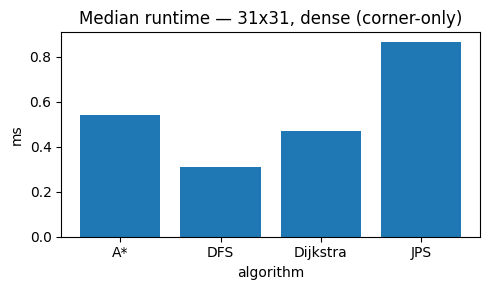

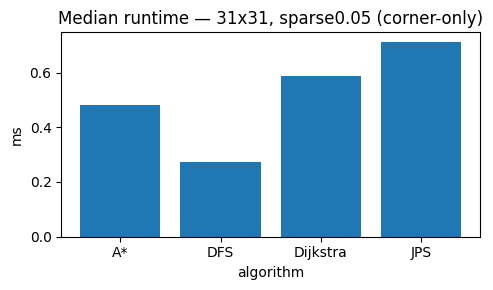

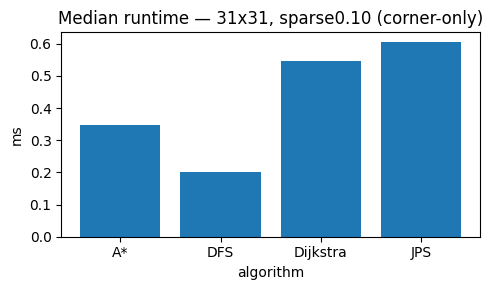

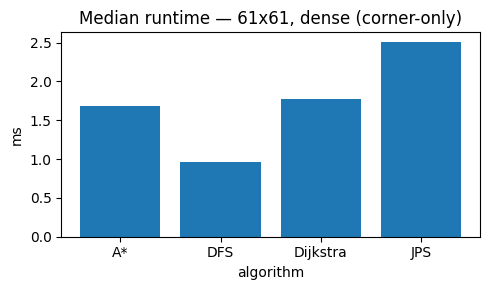

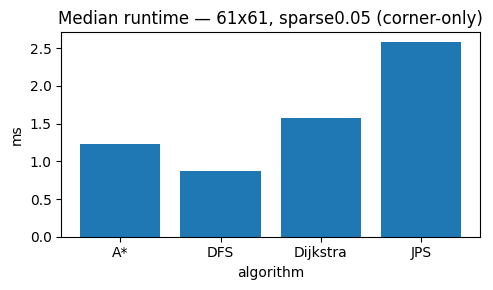

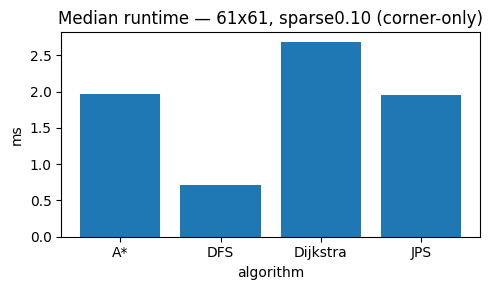

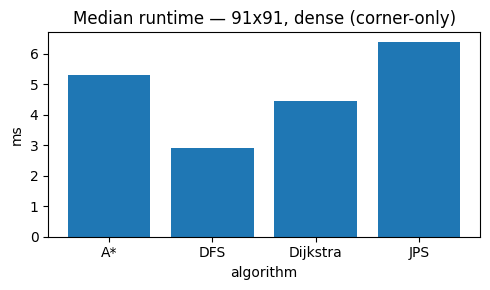

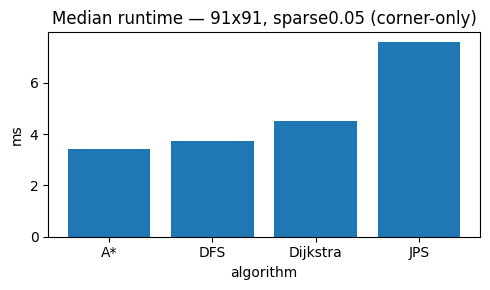

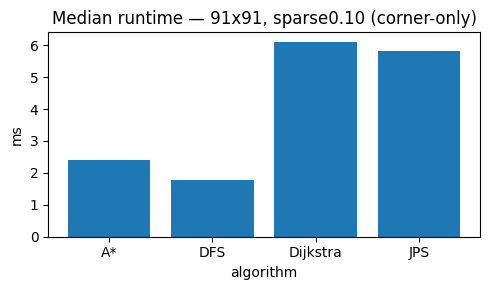

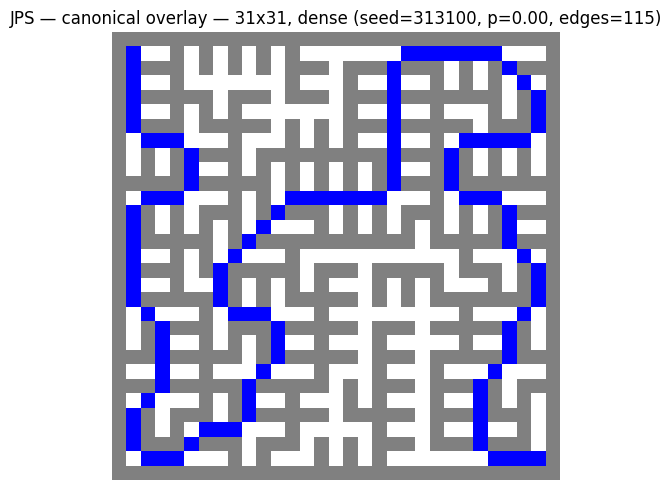

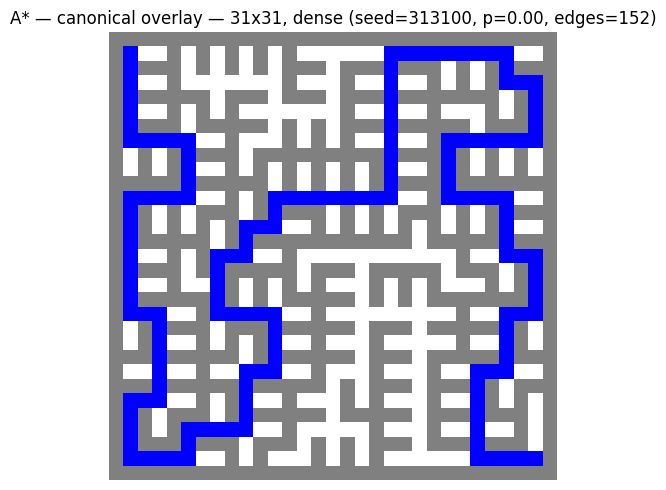

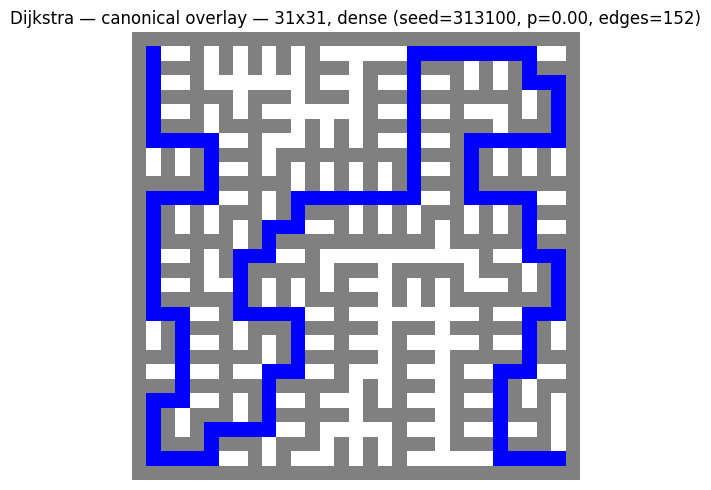

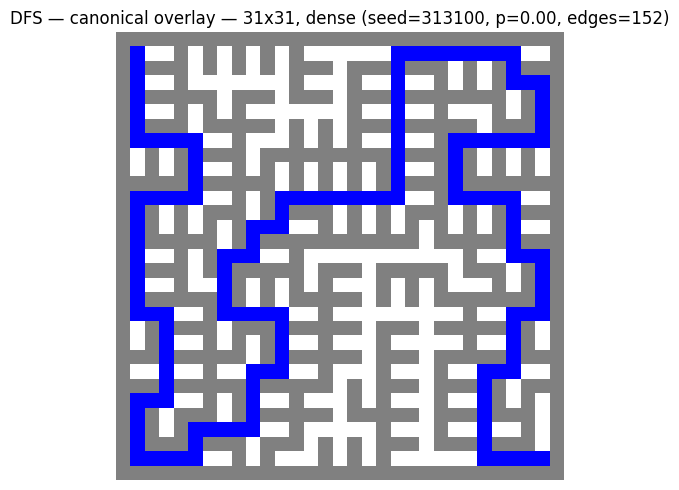

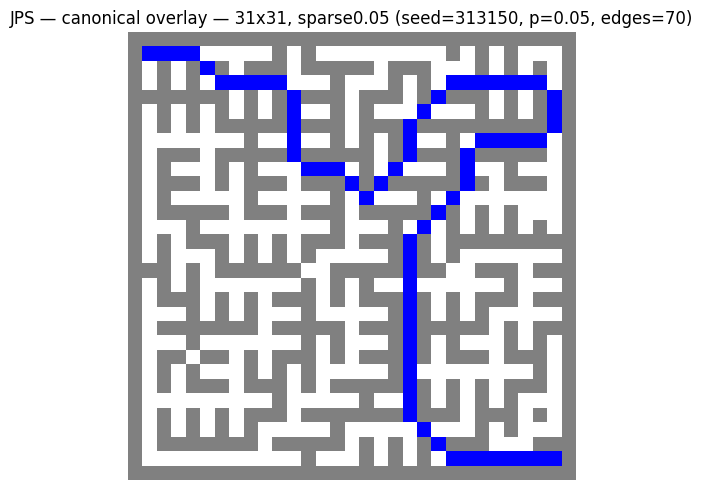

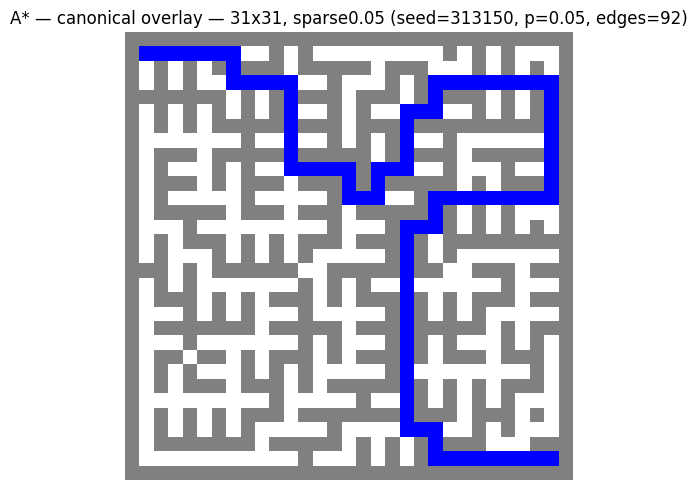

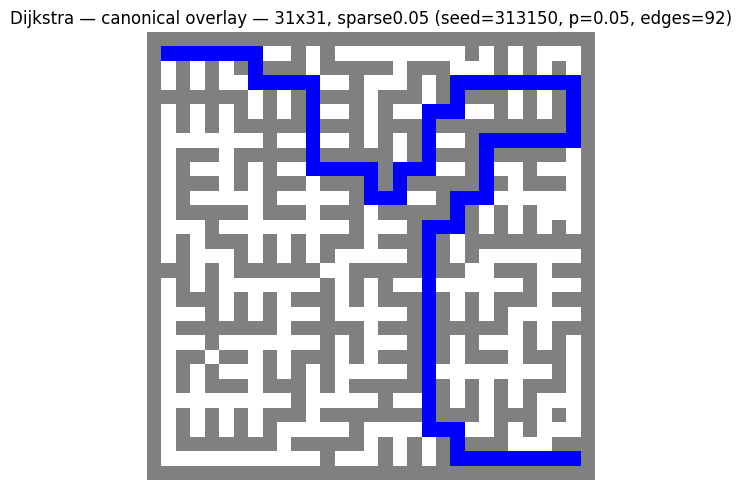

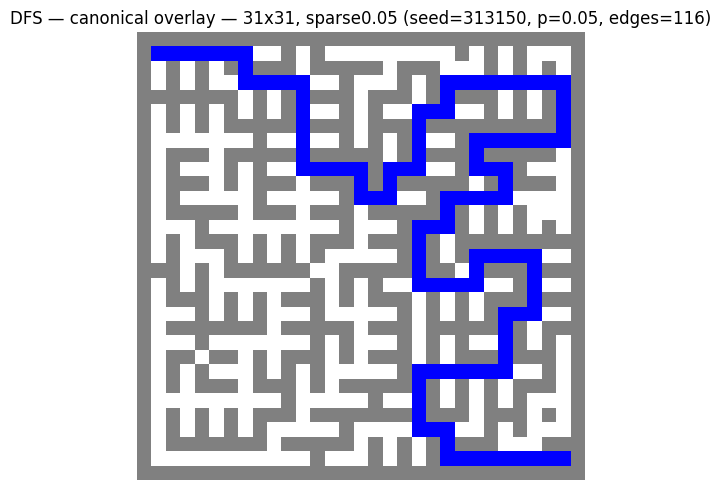

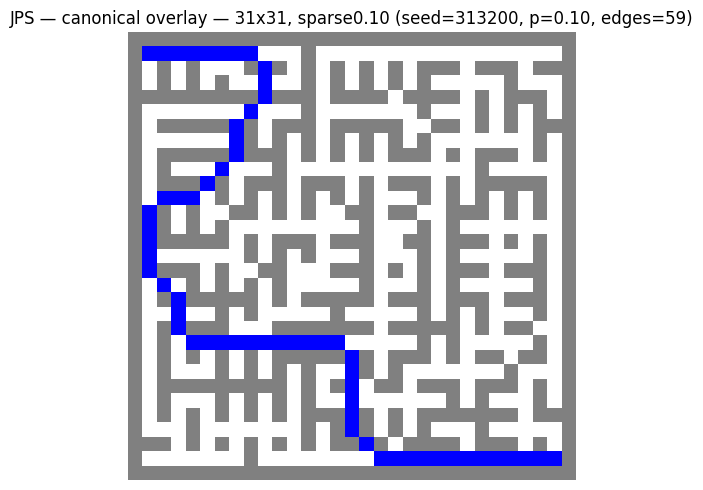

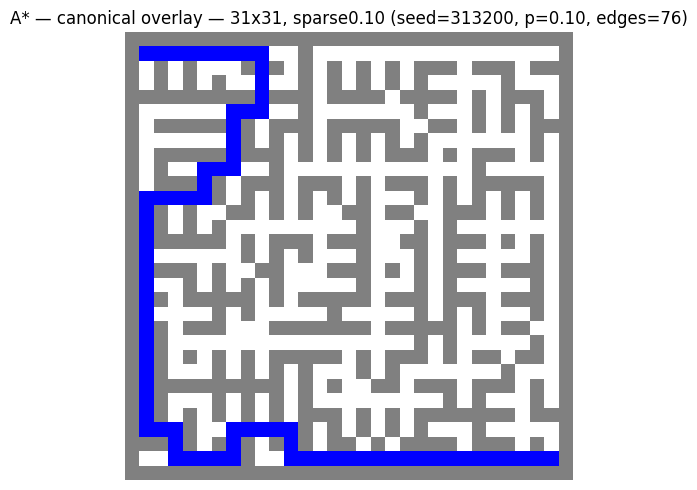

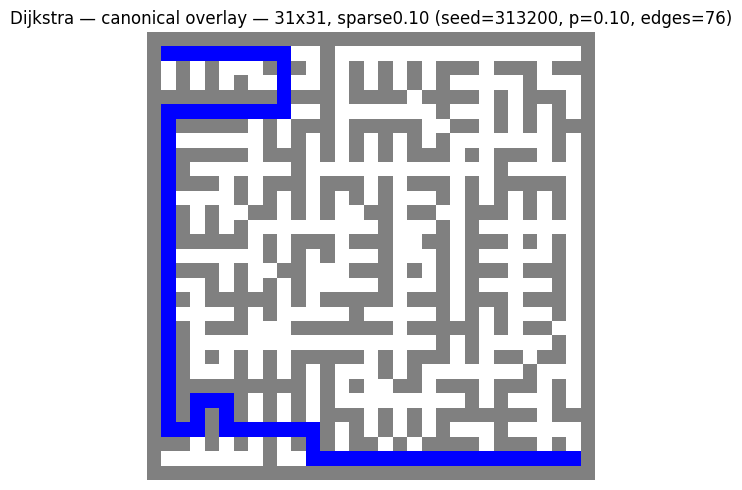

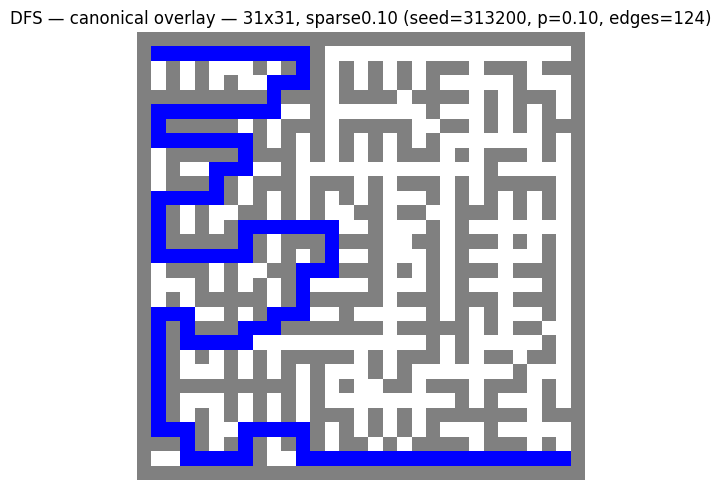

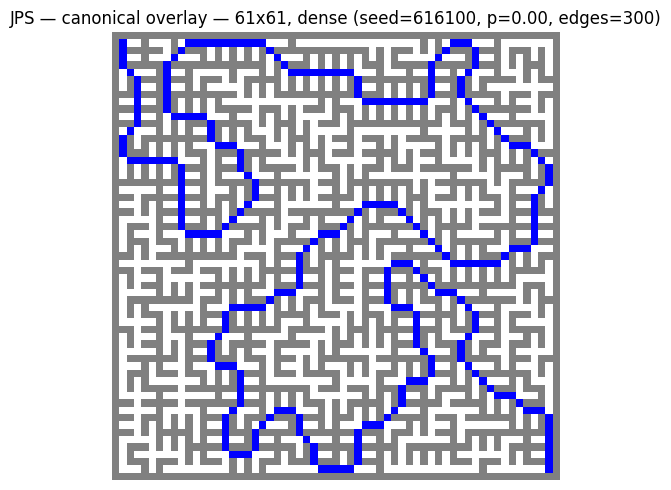

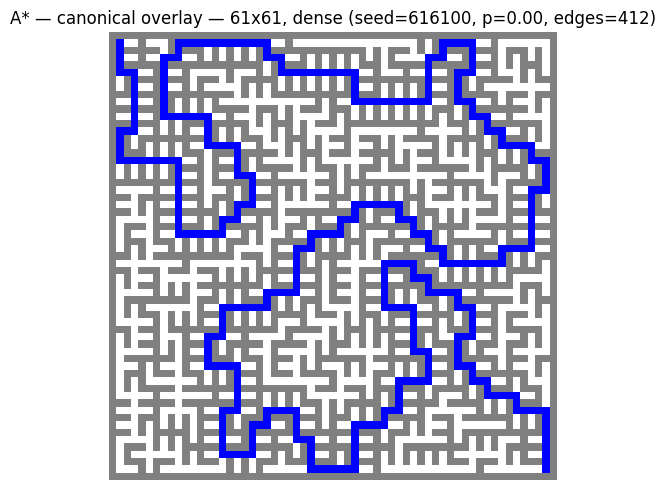

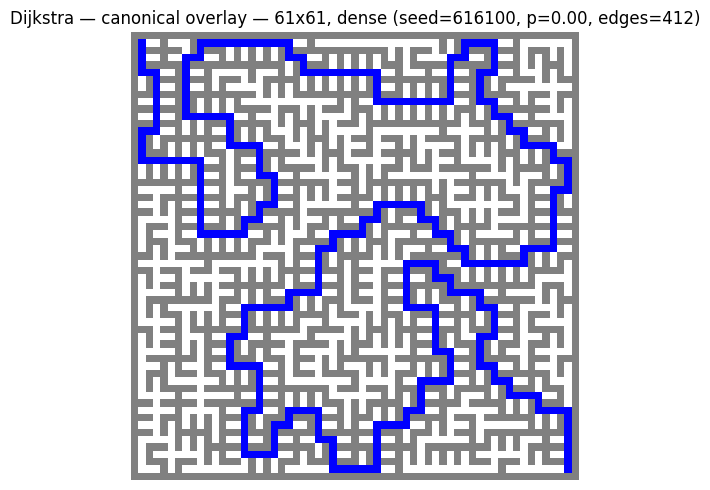

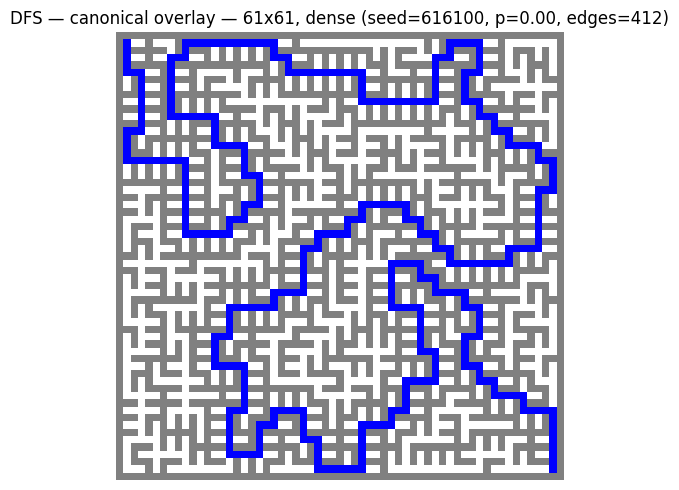

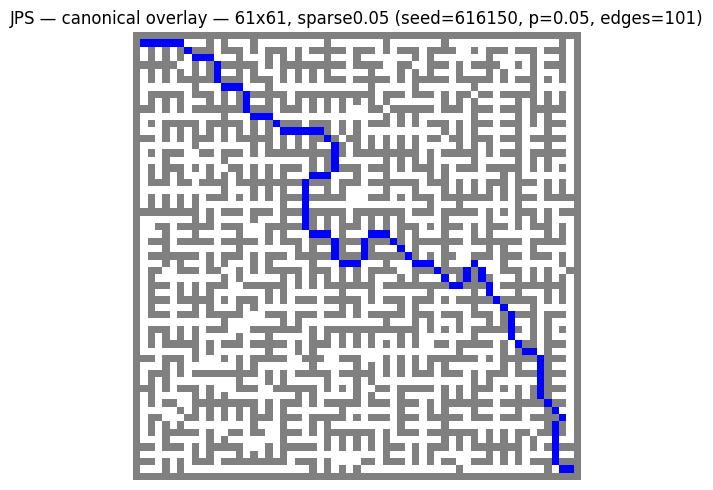

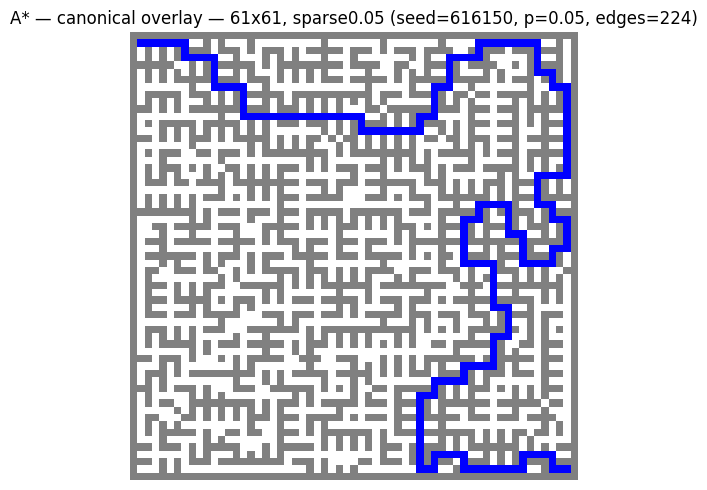

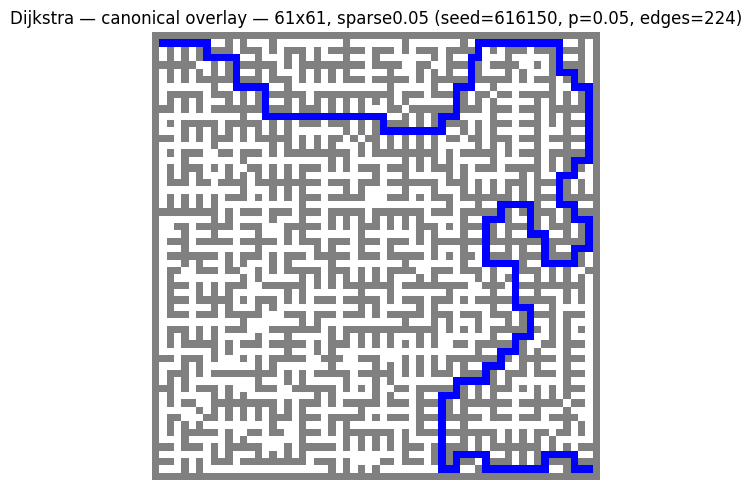

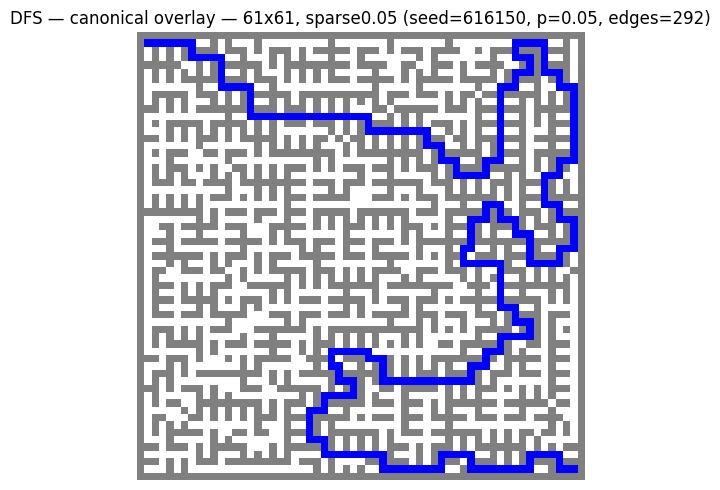

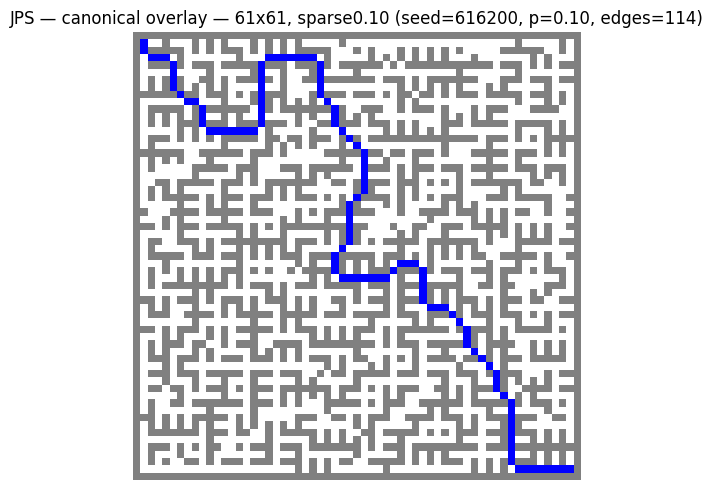

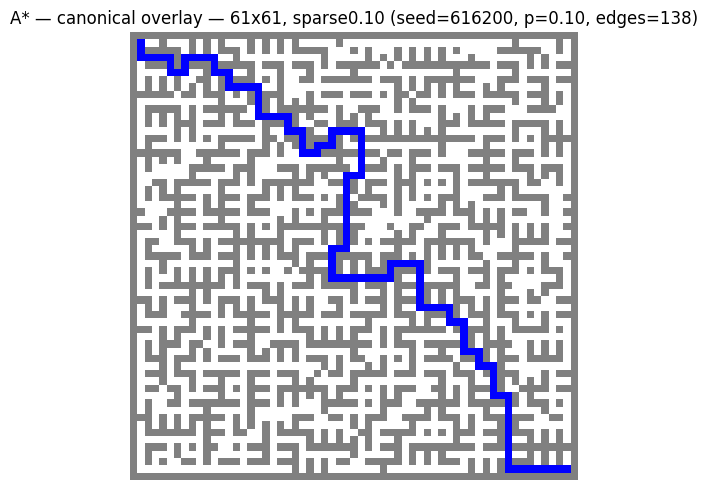

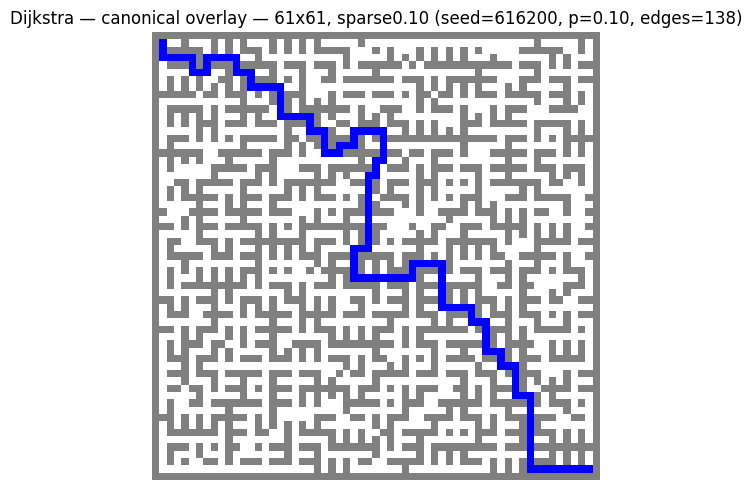

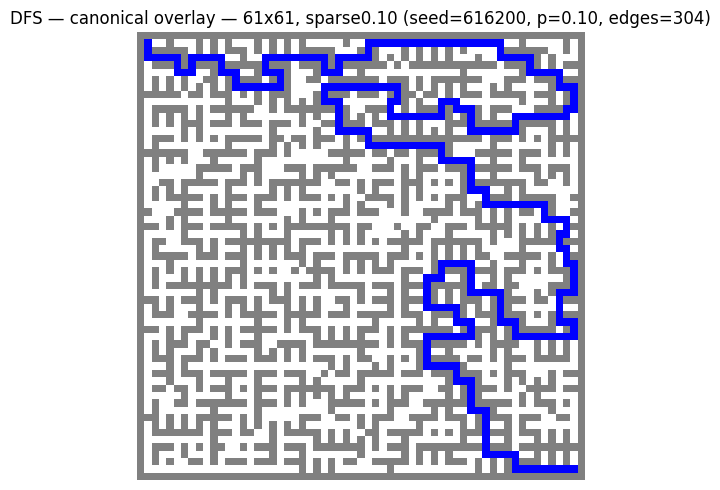

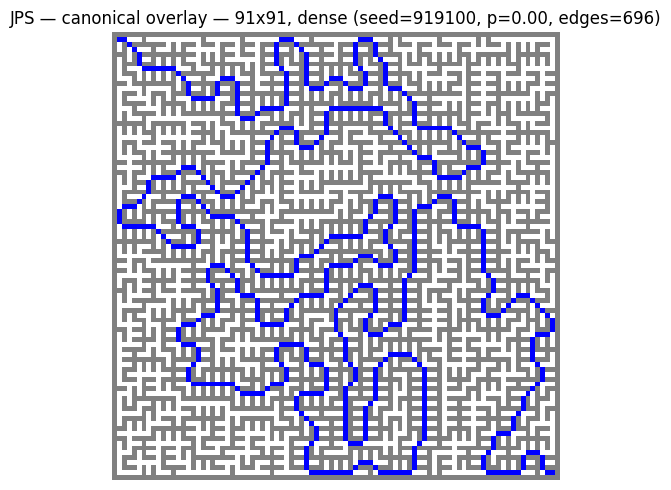

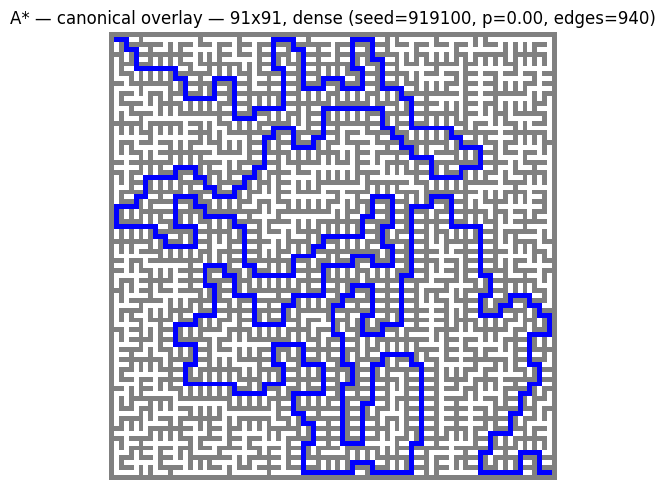

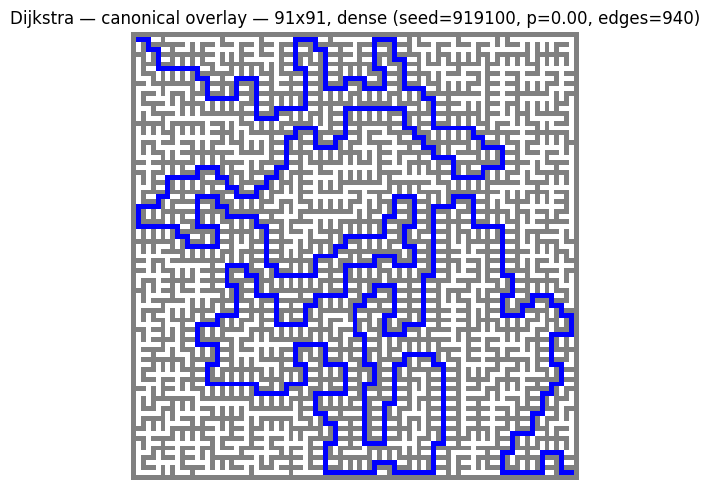

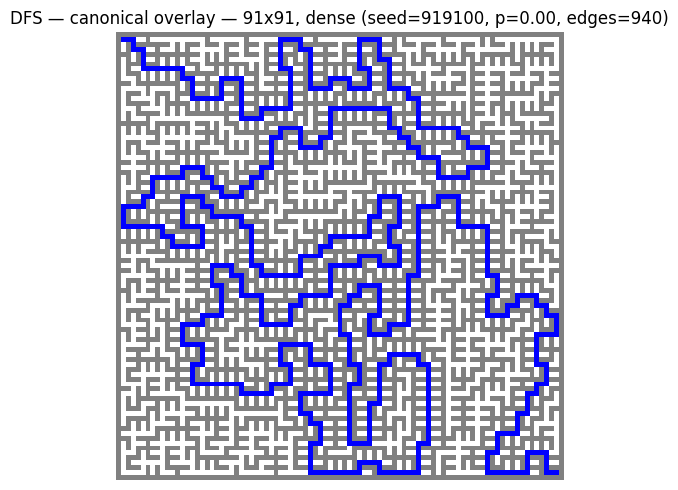

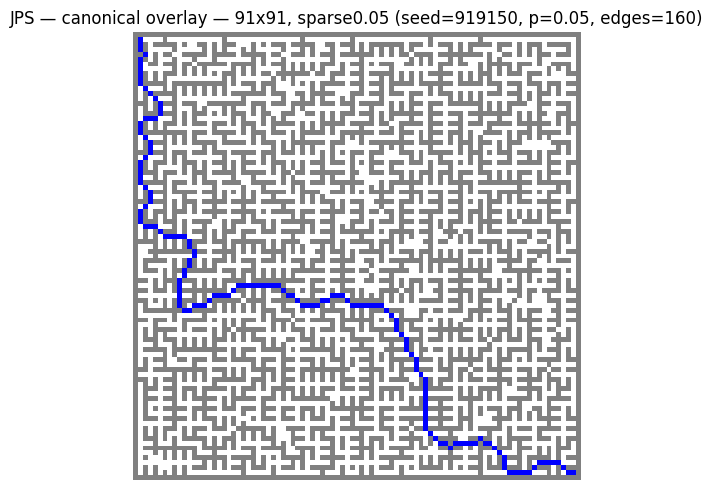

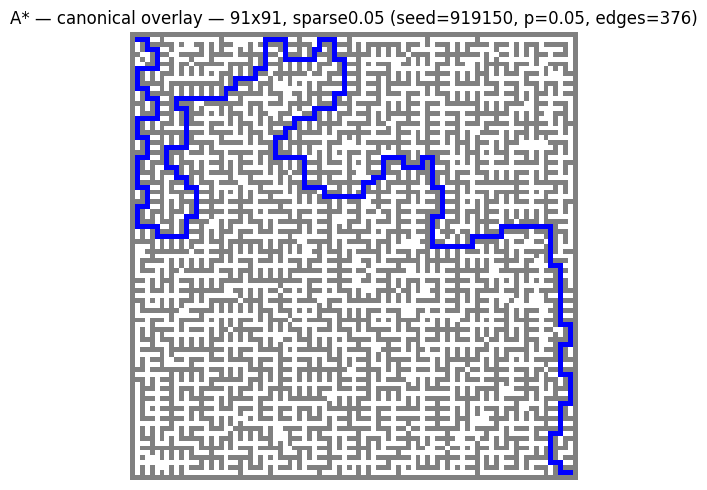

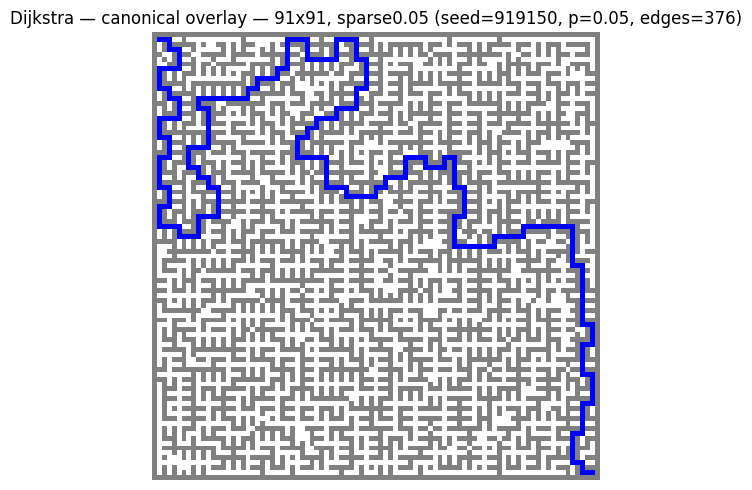

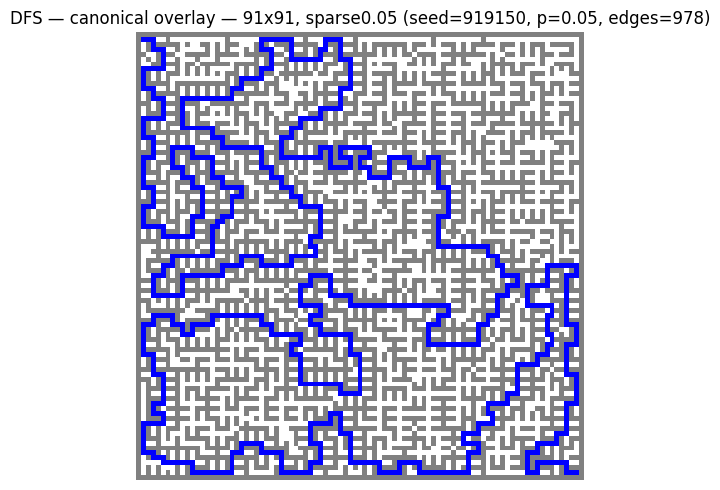

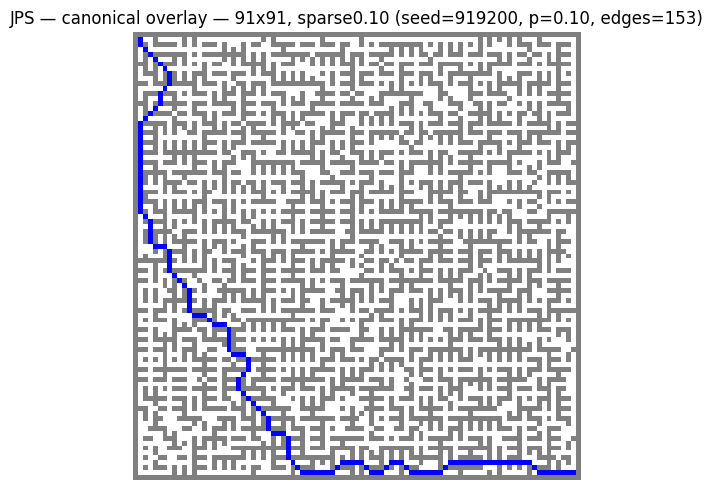

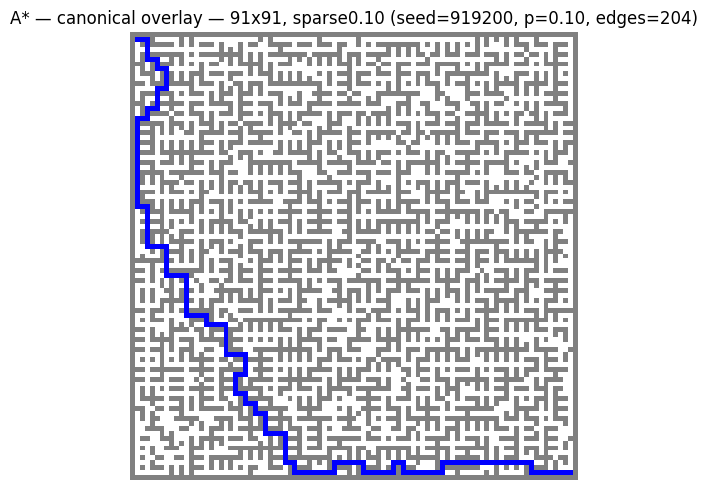

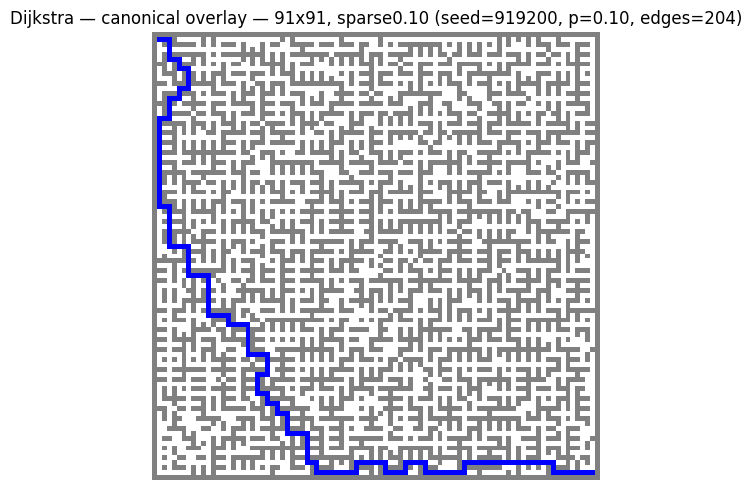

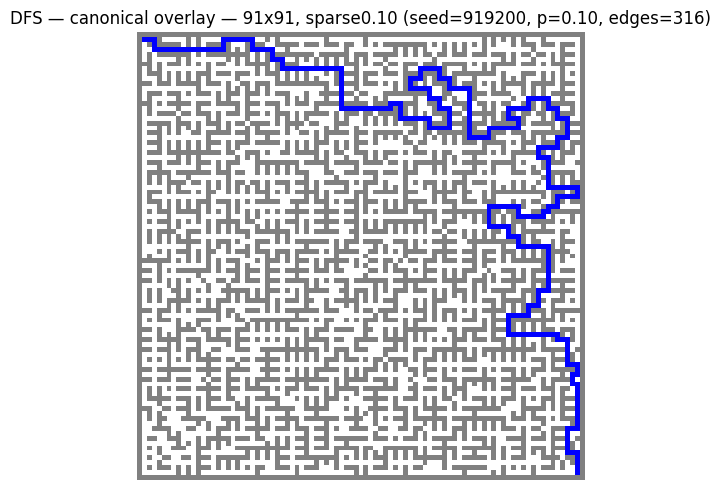

In [32]:

# Corner-only summaries and canonical overlays
def corner_view(df:pd.DataFrame)->pd.DataFrame: return df[df["is_corner"]==1].copy()

def summarize_corner_medians(df:pd.DataFrame)->pd.DataFrame:
    corner=corner_view(df)
    return (corner.groupby(["size","map_type","algo"])[["runtime_ms","expanded"]]
                  .median().reset_index())

med_table=summarize_corner_medians(df)
print(med_table.sort_values(["size","map_type","runtime_ms"]).head(12))

for (size,mtype),sub in med_table.groupby(["size","map_type"]):
    plt.figure(figsize=(5,3))
    plt.bar(sub["algo"],sub["runtime_ms"])
    plt.title(f"Median runtime — {size}, {mtype} (corner-only)")
    plt.ylabel("ms"); plt.xlabel("algorithm"); plt.tight_layout()
    fname=f"corner_median_runtime_{size}_{mtype}".replace("*","star").replace(" ","_")
    plt.savefig(os.path.join(ARTIFACTS,f"{fname}.png"),dpi=160); plt.show()

def best_run_heatmap(grid,path,title):
    img=grid.copy(); H,W=img.shape
    for y,x in path:
        if 0<=y<H and 0<=x<W: img[y,x]=2
    cmap=ListedColormap(["white","gray","blue"])
    plt.figure(figsize=(5,5)); plt.imshow(img,cmap=cmap,interpolation="none",vmin=0,vmax=2)
    plt.axis("off"); plt.title(title); plt.tight_layout()
    fname=title.replace("*","star").replace(" ","_").replace(",","").replace("—","-")
    plt.savefig(os.path.join(ARTIFACTS,f"overlay_{fname}.png"),dpi=160); plt.show()

def canonical_overlays_corners(df:pd.DataFrame)->None:
    fn={"A*":astar_metrics,"DFS":dfs_metrics,"Dijkstra":dijkstra_metrics,"JPS":jps_metrics}
    for size in sorted(df["size"].unique().tolist()):
        H,W=map(int,size.split("x"))
        start,end=(1,1),(H-2,W-2)
        for mtype in sorted(df["map_type"].unique().tolist()):
            base=df[(df["size"]==size)&(df["map_type"]==mtype)&(df["is_corner"]==1)]
            if base.empty: continue
            r=base.iloc[0]; seed=int(r["seed"]); pval=float(r["p"])
            M=generate_maze_dfs_seeded(W|1,H|1,seed=seed)
            G=M if pval==0.0 else add_loops(M,p=pval,seed=seed)
            for algo in ["JPS","A*","Dijkstra","DFS"]:
                out=fn[algo](G,start,end); path=out.get("path",[])
                title=f"{algo} — canonical overlay — {size}, {mtype} (seed={seed}, p={pval:.2f}, edges={max(0,len(path)-1)})"
                best_run_heatmap(G,path,title)

canonical_overlays_corners(df)
